[*********************100%***********************]  1 of 1 completed
Up trend
Date:60 Buy at the price 2063.949951171875
Date:140 Secure Profit Buy at the price 2175.030029296875
Up trend
Date:150 Buy at the price 2182.8701171875
Date:230 Secure Profit Buy at the price 2204.659912109375
Up trend
Date:236 Buy at the price 2241.35009765625
Date:316 Secure Profit Buy at the price 2360.159912109375
Up trend
Date:338 Buy at the price 2399.2900390625
Date:418 Secure Profit Buy at the price 2446.300048828125
Up trend
Date:426 Buy at the price 2488.110107421875
Date:506 Secure Profit Buy at the price 2723.989990234375
Up trend
Date:507 Buy at the price 2743.14990234375
Date:587 Secure Profit Buy at the price 2635.669921875
Up trend
Date:613 Buy at the price 2779.030029296875
Date:693 Secure Profit Buy at the price 2923.429931640625
Up trend
Date:790 Buy at the price 2792.669921875
Date:870 Secure Profit Buy at the price 2917.75
Up trend
Date:872 Buy at the price 2954.179931640625
Date:952 Secu

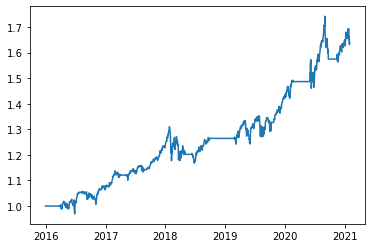

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import mplfinance as mpf

start = '2016-01-01'
end = dt.datetime.now()
stock_code = '^GSPC'
df = yf.download(stock_code, start, end, interval='1d')
# print(df.head(65))

# 何日間で最大最小の値を保持
shortTerm = 20
longTerm = 60

# 損切り率と利確の日数
stopLoss = 0.95
rikaku_day = 80

# judge U trend or Down trend by DC
buy_position = False # 1 means entered and 0 means not already entered
sell_position = False

# 買った（売った）後に経過した日数、損切りラインを保持
buy_dates = 0
sell_dates = 0
buy_stopLine = 0
sell_stopLine = 0
counter = 1
percentChange = []

# 資産、購入したときの資産
assets = [1]
buy_asset = 1

# chek the highest price in the past {term} times
df['Highest'+str(shortTerm)] = df.iloc[:, 4].rolling(window=shortTerm).max()
# chek the highest price in the past {term} times
df['Lowest'+str(shortTerm)] = df.iloc[:, 4].rolling(window=shortTerm).min()

# chek the highest price in the past {term} times
df['Highest'+str(longTerm)] = df.iloc[:, 4].rolling(window=longTerm).max()
# chek the highest price in the past {term} times
df['Lowest'+str(longTerm)] = df.iloc[:, 4].rolling(window=longTerm).min()

# df.iloc[:,1]
# df['Highest'+str(longTerm)][:65]
# df['Lowest'+str(longTerm)][:65]

"""
メインループ
基本戦略
過去longTerm間の調整済み終値の最高値をその日の調整済み終値が更新したら購入or空売り
損切り率は5%。80日後に利確する。
最終日にまだ保持していた場合捌く
"""
# for i in range(1, len(df)):
for i in range(1,len(df)):
        
    shortHighest = df['Highest'+str(shortTerm)][i-1]
    shortLowest = df['Lowest'+str(shortTerm)][i-1]
    longHighest = df['Highest'+str(longTerm)][i-1]
    longLowest = df['Lowest'+str(longTerm)][i-1] 
    # high_price = df['High'][i]
    # low_price = df['Low'][i]
    close = df['Adj Close'][i]
    
    if buy_position == False:
        assets.append(assets[i-1])
    else:
        assets.append(buy_asset*(close / buy_price))
        
    # avoid NaN data 
    # 買いトレンド
    if (np.isnan(longHighest)) == False:
        if (close > longHighest and buy_position == False):
            print('Up trend')
            buy_position = True
            buy_price = close
            buy_stopLine = close * stopLoss
            buy_asset = assets[i]
            print('Date:'+str(i),'Buy at the price {}'.format(buy_price))

    # 損切り
    if buy_position == True and close < buy_price*stopLoss:
        buy_position = False
        percent = (close/buy_price - 1) * 100
        percentChange.append(percent)
        buy_dates = 0
        print('Date:'+str(i),'Stop Loss Buy at the price {}'.format(close))

    # 利確
    if buy_dates == 80:
        buy_position = False
        percent = (close/buy_price - 1) * 100
        percentChange.append(percent)
        buy_dates = 0
        print('Date:'+str(i),'Secure Profit Buy at the price {}'.format(close))
        
    # 損切りラインの更新
    # if buy_position = 

    #  最終日にまだ持ってたら利確する
    if (counter == df['Adj Close'].count() - 1):
        if buy_position == True:
            buy_position = False
            percent = (close / buy_price - 1) * 100
            percentChange.append(percent)
            buy_dates = 0
            print('Date:'+str(i),'Last Day Buy at the price {}'.format(close))

    # 買ってからの日数を更新する
    if buy_position == True:
        buy_dates += 1
    counter += 1



print(percentChange)

# statistic
gains = 0
numGains = 0
losses = 0
numLosses = 0
total_return = 1

for i in percentChange:
    if i > 0:
        numGains += 1
        gains += i
    else:
        numLosses += 1
        losses += i
    total_return = total_return * ((i / 100) + 1)

total_return = round((total_return - 1)*100, 2)

if numGains > 0:
    average_gain = gains / numGains
    max_return = max(percentChange)
else:
    average_gain = 0
    max_return = 'unknown'
    
if numLosses > 0:
    average_loss = losses / numLosses
    max_loss = min(percentChange)
    risk_reward_retio = - average_gain / average_loss
else:
    average_loss = 0
    max_loss = 'unknown'
    risk_reward_retio = 'inf'
    
if numGains > 0 or numLosses > 0:
    batting_ratio = numGains / (numGains + numLosses)
else:
    batting_ratio = 0
    
print('The period is from {} up to {}'.format(df.index[0], df.index[-1]))
print('Trades: {}'.format(numGains+numLosses))
print('Total return: {}%'.format(total_return))
print('Average Gain: {}'.format(average_gain))
print('Average Loss: {}'.format(average_loss))
print('Max Return: {}'.format(max_return))
print('Max Loss: {}'.format(max_loss))
print('Gain/Loss Ratio: {}'.format(risk_reward_retio))
print('Batting Average: {}'.format(batting_ratio))

assets = np.array(assets)
print(assets)
print(assets.min())
print('{}%'.format((round((1-assets.min())*100,2))))
plt.plot(df.index,assets)
plt.show()

DatetimeIndex(['2015-12-31', '2016-01-04', '2016-01-05', '2016-01-06',
               '2016-01-07'],
              dtype='datetime64[ns]', name='Date', freq=None)
Buy at the price 2012.6600341796875
Sell at the price 3714.239990234375
[84.54383388937372]
The period is from 2015-12-31 00:00:00 up to 2021-01-29 00:00:00
Trades: 1
Total return: 84.54%
Average Gain: 84.54383388937372
Average Loss: 0
Max Return: 84.54383388937372
Max Loss: unknown
Gain/Loss Ratio: inf
Batting Average: 1.0
1279
0.9087873386427018
9.12%


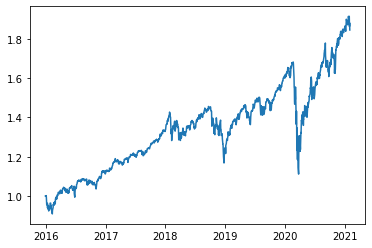

In [17]:
"""
メインループ
比較対象：最初の日に買って、最後の日に売る
"""

percentChange = []
counter = 1
print(df.index[:5])
assets = [1]

for i in range(1,len(df)):
#     print(counter)
#     print(counter,df.index[i])
#     print(buy_position, sell_position, buy_dates, sell_dates, buy_stopLine, sell_stopLine, 'Adj Close:{}'.format(df['Adj Close'][i]))
#     if counter == 100:
#         break
    close = df['Adj Close'][i]
    
    if i == 1:
        buy_price = close
        print('Buy at the price {}'.format(buy_price))
        
    if (counter == df['Adj Close'].count() - 1):
        percent = (close/buy_price - 1) * 100
        percentChange.append(percent)
        print('Sell at the price {}'.format(close))
    
    assets.append(1*(close/buy_price))
        
    counter += 1


print(percentChange)

# statistic
gains = 0
numGains = 0
losses = 0
numLosses = 0
total_return = 1

for i in percentChange:
    if i > 0:
        numGains += 1
        gains += i
    else:
        numLosses += 1
        losses += i
    total_return = total_return * ((i / 100) + 1)

total_return = round((total_return - 1)*100, 2)

if numGains > 0:
    average_gain = gains / numGains
    max_return = max(percentChange)
else:
    average_gain = 0
    max_return = 'unknown'
    
if numLosses > 0:
    average_loss = losses / numLosses
    max_loss = min(percentChange)
    risk_reward_retio = - average_gain / average_loss
else:
    average_loss = 0
    max_loss = 'unknown'
    risk_reward_retio = 'inf'
    
if numGains > 0 or numLosses > 0:
    batting_ratio = numGains / (numGains + numLosses)
else:
    batting_ratio = 0
    
print('The period is from {} up to {}'.format(df.index[0], df.index[-1]))
print('Trades: {}'.format(numGains+numLosses))
print('Total return: {}%'.format(total_return))
print('Average Gain: {}'.format(average_gain))
print('Average Loss: {}'.format(average_loss))
print('Max Return: {}'.format(max_return))
print('Max Loss: {}'.format(max_loss))
print('Gain/Loss Ratio: {}'.format(risk_reward_retio))
print('Batting Average: {}'.format(batting_ratio))

assets = np.array(assets)
print(len(assets))
print(assets.min())
print('{}%'.format((round((1-assets.min())*100,2))))
plt.plot(df.index,assets)
plt.show()